In [12]:
!pip install tdqm -q


In [ ]:
# Data and Path
from tqdm import tqdm
from glob import glob
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_ar

In [14]:
# Basic and Data
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

In [53]:
# Model and layers
from keras.models import Model
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate, Reshape, Lambda
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import LeakyReLU, ReLU
from keras.models import Sequential


In [16]:
#Backbone
from tensorflow.keras.applications import ResNet50

#Architecture and Visulization
from tensorflow.keras.utils import plot_model

#Optimizer

from tensorflow.keras.optimizers import Adam

# Callbacks
from keras.callbacks import ModelCheckpoint, Callback

# Model Layer Visualization
from tf_explain.core.grad_cam import GradCAM


# Prepare and Configuration

In [65]:
root_path = r'D:\WORK\Python\Project\CV\flood_map_segmentation\floodmap_segmentation\data'
image_path = r'D:\WORK\Python\Project\CV\flood_map_segmentation\floodmap_segmentation\data\Image'
mask_path = r'D:\WORK\Python\Project\CV\flood_map_segmentation\floodmap_segmentation\data\Mask'
metadata_path = r"D:\WORK\Python\Project\CV\flood_map_segmentation\floodmap_segmentation\data\metadata.csv"

In [66]:

meta_df = pd.read_csv(metadata_path)
meta_df

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png
...,...,...
285,1083.jpg,1083.png
286,1084.jpg,1084.png
287,1085.jpg,1085.png
288,1086.jpg,1086.png


## Loading Image and Data Loader 


In [67]:
# This is a helper function
def load_image(path:str, SIZE:tuple = (256, 256), mask:bool = False):
    
    '''
    This function is responsible for loading and processing the image. The function takes in the path of the 
    image to be loaded and then loads the image using OpenCV, perform a resize conversionn and cast the image
    to a 32Bit Float Tensor. At last, the image is normalized to change the pixel range from 0 to 255 to
    0 to 1.
    
    Inputs : 
        path : It represents the file path of he image to be loaded.
        size : The desired size in which the image should be resized, default is set to 256 x 256 pixels.
        mask : If the image to be loaded is then the image is a binary map i.e of shape = (*size, 1)
    
    Output:
        image : The processed image whose file path was provided.
    '''
    
    # load Image
    image = load_img(path)
    
    # Convert to an array
    image = img_to_array(image)
    
    # Resize the image
    image = tfi.resize(image, SIZE)
    
    # Convert to Tensor of 32Bit - Float
    image = tf.cast(image, tf.float32)
    
    # Normalize the image
    image = image/255.
    
    # Mask
    if mask:
        image = image[:, :, :1]
        
    # return image
    return image

In [68]:
def load_data(root_path:str=root_path):
    
    '''
    The function is reponsible for loading all the Images and their respective Masks. It does so by first load the file paths of the Images
    then it applies some changes on the Image paths to convert them to Mask Paths. Before loading the Images and Masks, first a empty space
    is created, where the loaded Images and Masks are stored. As last it returns the array of Images and Masks.
    
    Input : 
        root_path : The path to the main directory where both the images & masks are kept.
    
    Outputs : 
        images : Array of all the images present in the data set.
        masks : Array of all the masks present in the data set.
    '''
    
    # Load the Image and Mask paths
    image_paths = sorted(glob(root_path + "Image/*.jpg"))
    mask_paths  = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]
    
    # Create space for loading the images and masks
    images = np.empty(shape=(len(image_paths), 256, 256, 3), dtype=np.float32)
    masks  = np.empty(shape=(len(image_paths), 256, 256, 1), dtype=np.float32)
    
    # load the images and masks
    for i, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):

        # Load the image
        image = load_image(path = img_path, mask = False)
        
        # Load the respective mask
        mask  = load_image(path = mask_path, mask = True)
        
        # Put this into the Space
        images[i] = image
        masks[i]  = mask
    
    # Return the images and Masks
    return images, masks

In [69]:
# Colect All images and masks 
all_images, all_masks = load_data(root_path)

Loading: 0it [00:00, ?it/s]


In [70]:
# Split data into Training and Testing
data_len = len(all_images)

# Training set
train_images, train_masks = all_images[:int(data_len*0.8)], all_masks[:int(data_len*0.8)]

# Testing Set
test_images,  test_masks = all_images[int(data_len*0.8):], all_masks[int(data_len*0.8):]

## Getting pair of image and mask

In [72]:
# Split data into Training and Testing
data_len = len(all_images)

# Training set
train_images, train_masks = all_images[:int(data_len*0.8)], all_masks[:int(data_len*0.8)]

# Testing Set
test_images,  test_masks = all_images[int(data_len*0.8):], all_masks[int(data_len*0.8):]

## Data Visulization

In [73]:
def show_images(images, masks, n_images, SIZE=(15,8)) -> None:
    
    '''
    This function is responsible for visualising N number of images from the given set of Images and the respective masks.
    It does so by plotting the images and masks using matplotlib.
    
    Inputs : 
        images   : The collection of images.
        masks    : The collection of masks.
        n_images : Total number of images to be plotted.
        SIZE     : Size of each plot.
        
    '''
    
    # Plot n Images
    for i in range(n_images):

        # Plotting Configuration
        plt.figure(figsize=SIZE)
    
        # Select a image Randomly
        id = np.random.randint(len(images))
        
        # Plot the Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[id])
        plt.title("Image")
        plt.axis('off')
        
        # Plot the Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[id], cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        # Plot the Overlapping Mask
        plt.subplot(1, 3, 3)
        plt.imshow(images[id], cmap='gray')
        plt.imshow(masks[id], cmap='gray', alpha=0.5)
        plt.title("Overlapping Mask")
        plt.axis('off')
        
        # Shwo a Single Frame : This is done to speed up plotting for large number images
        plt.tight_layout()
        plt.show()

In [74]:
show_images(train_images, train_masks, n_images=10)


ValueError: high <= 0

<Figure size 1500x800 with 0 Axes>

# DeepLabV3+ 

DeepLabV3+ is an Encoder-Decoder Model which is an upgraded version of DeepLabV3. The Model Architectre used Atrous Spatial Pyramid Pooling for extracting information from the Feature Maps of the ResNet50 Model from different Scales. They extract the High Level Information from the Higher Feature Maps of the ResNet50 for better understanding of the Object present in the Image, whereas for understanding the Spatial features of the image it takes feature maps from Lower Layers i.e. extracts Lower Level Information, such as geometry. Then the model concatenates both the High Level Features and Lower Level Features for producing the Final Mask.

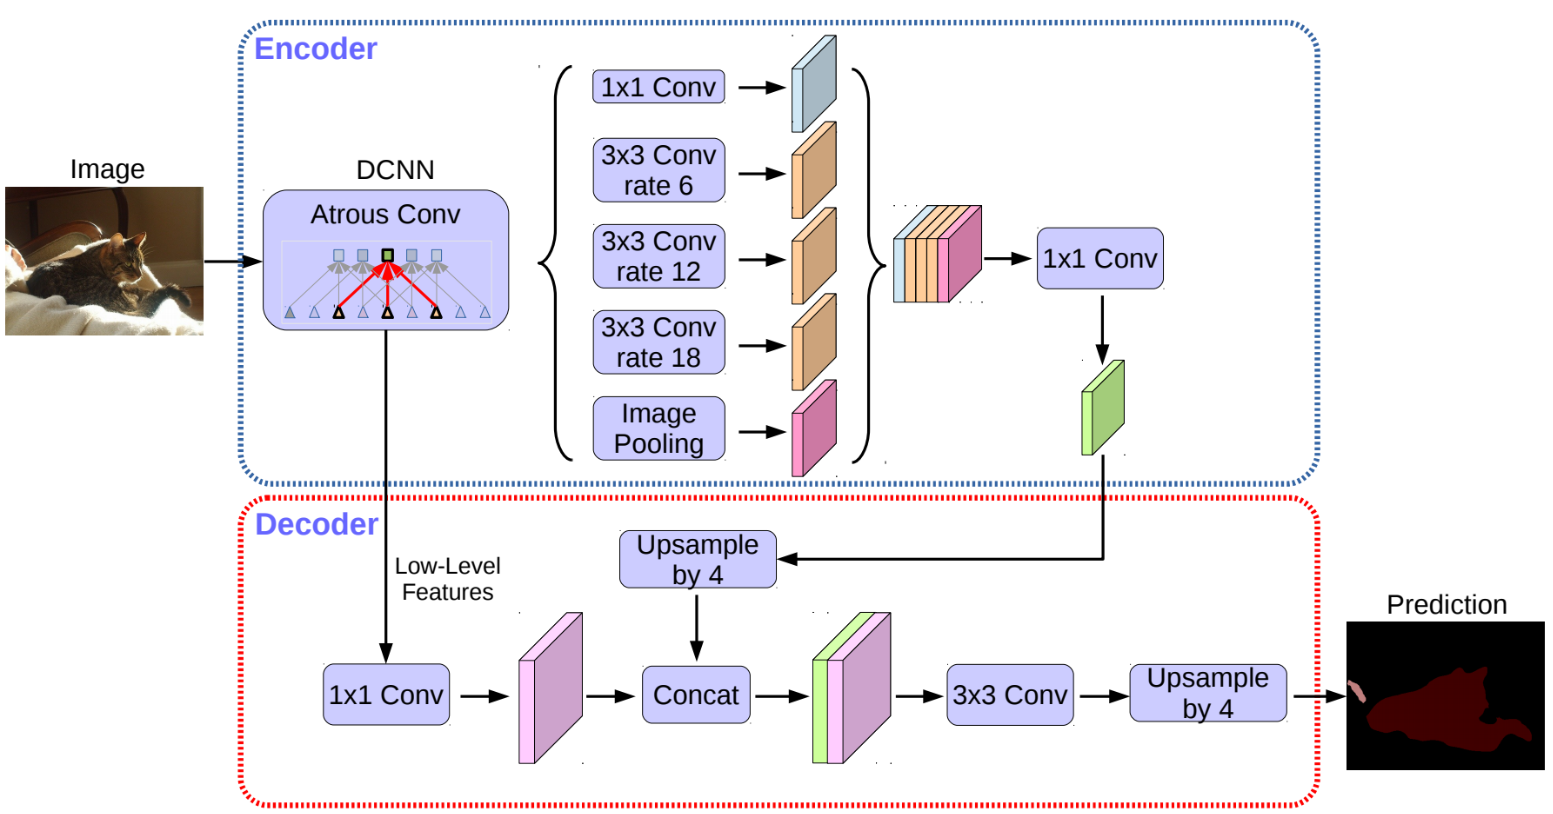

In [ ]:
class Conv_Block(Layer):
    
    '''
    As in the Model implementation uses, Conv2D -> BatchNormalization -> ReLU. In the same fashion again and again, that why we have created a Single Layer
    which apply this operation. So ConvBlock = Conv2D -> BatchNormalization -> ReLU. This helps us in implementation.
    '''
    
    def __init__(self, filters:int = 256, kernel_size:int = 3, dilation_rate:int = 1, **kwargs) -> None:
        super(ConvBlock, self).__init__(**kwargs)
        
        # Define Parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        
        # Define the model 
        self.net = Sequential([
            Conv2D(filters,
                   kernel_size=kernel_size,
                   padding='same', 
                   strides=1, dilation_rate=dilation_rate,
                   activation=None,
                   use_bias=False),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, X):
        # Apply the layers
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate
        }

## Astrous Pyramid Architecture

In [43]:
def AtrousSpatialPyramidPooling(X):
    
    # Shape
    _, H, W, C = X.shape
    
    # Image Pooling 
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-ImagePool-AP")(X)
    image_pool = Conv_Block(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[1]), name="ASPP-ImagePool-US")(image_pool)
    
    # Astrous Layers
    conv_1  = Conv_Block(kernel_size=1, dilation_rate=1, name="ASPP-Conv1")(X)
    conv_6  = Conv_Block(kernel_size=3, dilation_rate=6, name="ASPP-Conv6")(X)
    conv_12 = Conv_Block(kernel_size=3, dilation_rate=12, name="ASPP-Conv12")(X)
    conv_18 = Conv_Block(kernel_size=3, dilation_rate=18, name="ASPP-Conv18")(X)
    
    # Combine All
    combined = Concatenate(name="ASPP-Concatenate")([image_pool, conv_1, conv_6, conv_12, conv_18])
    output = Conv_Block(kernel_size=1, name="ASPP-Out")(combined)
    
    return output

In [55]:
def Conv_Block(x, filters=256, kernel_size=3, name=None):
    """Conv -> BN -> ReLU block"""
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", use_bias=False, name=f"{name}_conv")(x)
    x = BatchNormalization(name=f"{name}_bn")(x)
    x = Activation("relu", name=f"{name}_relu")(x)
    return x


def AtrousSpatialPyramidPooling(x, name="ASPP"):
    """ASPP block with atrous rates + global pooling"""

    # 1x1 conv
    conv1 = Conv_Block(x, filters=256, kernel_size=1, name=f"{name}_conv1")

    # 3x3 atrous convs
    conv6  = Conv_Block(Conv2D(256, 3, padding="same", dilation_rate=6, use_bias=False, name=f"{name}_conv6")(x),
                        filters=256, name=f"{name}_conv6_post")
    conv12 = Conv_Block(Conv2D(256, 3, padding="same", dilation_rate=12, use_bias=False, name=f"{name}_conv12")(x),
                        filters=256, name=f"{name}_conv12_post")
    conv18 = Conv_Block(Conv2D(256, 3, padding="same", dilation_rate=18, use_bias=False, name=f"{name}_conv18")(x),
                        filters=256, name=f"{name}_conv18_post")

    # Image-level features
    pooled = GlobalAveragePooling2D(name=f"{name}_gap")(x)
    pooled = Reshape((1, 1, -1))(pooled)
    pooled = Conv_Block(pooled, filters=256, kernel_size=1, name=f"{name}_pooled")

    # Resize pooled features back to match input feature size
    pooled = Lambda(
        lambda t: tf.image.resize(t, (tf.shape(x)[1], tf.shape(x)[2])),
        output_shape=lambda s: (s[0], x.shape[1], x.shape[2], s[-1]),
        name=f"{name}_upsample"
    )(pooled)

    # Concatenate all features
    concat = Concatenate(name=f"{name}_concat")([conv1, conv6, conv12, conv18, pooled])
    output = Conv_Block(concat, filters=256, kernel_size=1, name=f"{name}_output")

    return output




def DeepLabV3(input_shape=(256, 256, 3), model_name="DeepLab-FloodArea"):
    """DeepLabV3 with ResNet50 backbone"""
    IMAGE_SIZE = input_shape[0]
    inputs = Input(shape=input_shape, name="InputLayer")

    backbone = ResNet50(input_tensor=inputs, weights="imagenet", include_top=False)

    # High-level features (stride 16)
    DCNN = backbone.get_layer("conv4_block6_2_relu").output
    ASPP = AtrousSpatialPyramidPooling(DCNN, name="ASPP")
    ASPP = UpSampling2D(size=(2, 2), interpolation="bilinear", name="ASPP-Upsample")(ASPP)  # (64, 64, 256)

    # Low-level features (stride 4)
    LLF = backbone.get_layer("conv2_block3_2_relu").output
    LLF = Conv_Block(LLF, filters=48, kernel_size=1, name="LLF-ConvBlock")

    # Combine
    concat = Concatenate(axis=-1, name="Concat-LLF-HLF")([LLF, ASPP])
    y = Conv_Block(concat, filters=256, kernel_size=3, name="TopConvBlock1")
    y = Conv_Block(y, filters=256, kernel_size=3, name="TopConvBlock2")

    # Upsample back to input size
    y = UpSampling2D(size=(IMAGE_SIZE // y.shape[1], IMAGE_SIZE // y.shape[2]),
                     interpolation="bilinear", name="Final-Upsample")(y)

    output = Conv2D(filters=1, kernel_size=1, activation="sigmoid", name="OutputLayer")(y)

    return Model(inputs, output, name=model_name)


In [58]:
# Model Specifications
IMAGE_SIZE = 256
MODEL_NAME = "DeepLabV3-VinThanh_FloodArea"

# Input Layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Backbone
backbone = ResNet50(input_tensor=inputs, weights='imagenet', include_top=False)

# High Level Features
DCNN = backbone.get_layer('conv4_block6_2_relu').output   # (32, 32, 1024)
ASPP = AtrousSpatialPyramidPooling(DCNN, name="ASPP")     # (32, 32, 256)

# Upsample ASPP to match LLF (32→64)
ASPP = UpSampling2D(size=(2, 2), interpolation="bilinear", name="ASPP-Upsample")(ASPP)  # (64, 64, 256)

# Low Level Features
LLF = backbone.get_layer('conv2_block3_2_relu').output    # (64, 64, 256)
LLF = Conv_Block(LLF, filters=48, kernel_size=1, name="LLF-ConvBlock")  # (64, 64, 48)

# Combine
concat = Concatenate(axis=-1, name="Concat-LLF-HLF")([LLF, ASPP])  # both are (64,64,...)

# Decoder
y = Conv_Block(concat, filters=256, kernel_size=3, name="TopConvBlock1")
y = Conv_Block(y, filters=256, kernel_size=3, name="TopConvBlock2")

# Upsample to match input size (64→256 needs 4x)
y = UpSampling2D(size=(4, 4), interpolation="bilinear", name="Feature-UpSample")(y)  # (256, 256, 256)

# Output Layer
output = Conv2D(filters=1, kernel_size=1, activation='sigmoid', name="OutputLayer")(y)

# Model
DeepLabV3 = Model(inputs, output, name=MODEL_NAME)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 64, 64, 48), (None, 32, 32, 256)]